# Train a Model to Classify Digits in Small Images

This notebook focuses on training a model to classify small images that conatain a single digit (0-9). The classifier will be integrated into a **Sudoku Solver program**, where it will identify digits from images of Sudoku quizes. By accurately recognizing digits in Sudoku cells, the model will enable the solver to process and solve puzzles from images.

## Objectives
1. **Dataset Creation**: Generate a dataset of small digit images by augmenting a set of template images.
2. **Model Training with Scikit-learn**: Train and evaluate traditional machine learning models using Scikit-learn.
3. **CNN Model with TensorFlow**: Build, train, and test a Convolutional Neural Network (CNN) using TensorFlow for improved accuracy.

---

### Key Steps
1. **Dataset Preparation**:
   - Start with a small set of template digit images.
   - Apply transformations (scaling and shifting) to create a diverse dataset.

2. **Scikit-learn Models**:
   - Train baseline models (SVM and SGD) to classify digits.
   - Evaluate performance using accuracy.

3. **CNN with TensorFlow**:
   - Design a CNN architecture suitable for small image classification.
   - Train the model and tune hyperparameters for optimal performance.
   - Compare results with Scikit-learn models to highlight the advantages of deep learning.

---

By the end of this notebook, you will have a trained model capable of accurately classifying digits, which can be seamlessly integrated into a Sudoku Solver program.

In [1]:
import numpy as np
import cv2 as cv
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from PIL import Image
import os
import random
import matplotlib.pyplot as plt
import shutil
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [126]:
# Gloabl Vars
digit_templates = {}

## Helper Functions

In [165]:
def crop_img(img, scale=1.0):
    """
    Crops and image from the center.
    """
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    return img_cropped

def load_templates():
    """
    Load template digits into the digit_templates dictionary.
    """
    global digit_templates

    dir = r'/content/sample_data/digit_templates'
    files = os.listdir(dir)
    for file in files:
        img = cv.imread(os.path.join(dir,file), cv.IMREAD_GRAYSCALE)
        img = cv.GaussianBlur(img,(23,23),0)
        img = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,23,1)
        img = crop_img(img, 0.8)
        img = cv.resize(img, (32,32), interpolation=cv.INTER_NEAREST)
        file_name = os.path.splitext(os.path.basename(file))[0]
        digit_templates[file_name]  = img

def plot_digit_templates():
    """
    Plots the template data.
    """
    global digit_templates

    num_digits = len(digit_templates)  # Number of images
    fig, axes = plt.subplots(1, num_digits, figsize=(num_digits * 2, 2))

    if num_digits == 1:  # Handle case for single image
        axes = [axes]

    for ax, (digit, image) in zip(axes, digit_templates.items()):
        ax.imshow(image, cmap='gray', vmin=0, vmax=255)  # Adjust cmap for grayscale
        ax.set_title(f"Digit: {digit}")
        ax.axis("off")  # Hide axes

    plt.show()

def augment_image(img):
    """
    Augments an image by applying scaling, sfifting and thresholding.
    """
    rows, cols = img.shape

    # Scaling (zoom in/out)
    scale_factor = np.random.uniform(0.8, 1.2)  # Scale between 80% and 120%
    M_scale = cv.getRotationMatrix2D((cols / 2, rows / 2), 0, scale_factor)
    img_scaled = cv.warpAffine(img, M_scale, (cols, rows), borderMode=cv.BORDER_CONSTANT, borderValue=255)

    # Shifting (up, down, left, right)
    max_shift = int(0.2*rows)
    shift_range = int(max_shift*(1/scale_factor))
    shift_x = np.random.uniform(-shift_range, shift_range)
    shift_y = np.random.uniform(-shift_range, shift_range)
    M_shift = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    img_shifted = cv.warpAffine(img_scaled, M_shift, (cols, rows), borderMode=cv.BORDER_CONSTANT, borderValue=255)
    kernel_size = random.choice([3,5,7,9])
    img_aug = cv.adaptiveThreshold(img_shifted,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,kernel_size,1)

    return img_aug

def prep_model_input(img):
    """
    Converts image into format for the tf CNN model.
    """
    img = 255-img
    img = img / 255.0
    img_array = tf.expand_dims(img, axis=0)
    return img_array

def scikit_image_preprocessing(img):
    """
    Prepare image data for scikit learn models
    """
    image_size = (32, 32)  # Resize all images to 32x32
    img = cv.resize(img, image_size)  # Resize to 32x32
    img_flattened = img.flatten()  # Convert 32x32 image to a 1024-dim vector
    np.array(img_flattened, dtype=np.float32)
    img_norm = img_flattened / 255.0
    return img_norm

def tf_image_preprocessing(img, label):
    img = 255-img
    return tf.cast(img, tf.float32)/255.0, label

## View Digit Templates

These are the images that will be used to create a larger dataset, through augmentation.

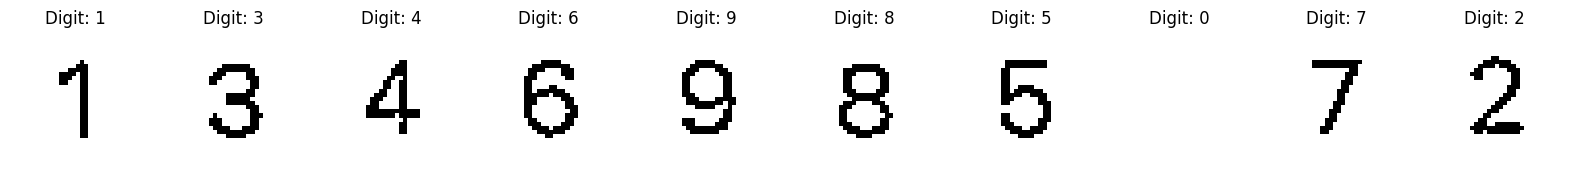

In [128]:
load_templates()
plot_digit_templates()

## Create a Dataset of Augmented Images

For augmentation, only shifting and zooming are applied. The images are binary (0 or 255), and the shape of the digit is slightly altered due to adaptive thresholding, which is applied with random kernel sizes. Shifting is performed so that the digit always remains completely within the image.

Below is an example of how augmentation can alter the image.

To create the dataset, 100 versions of each template image are generated. The dataset can be downloaded if this notebook is run in Google Colab.


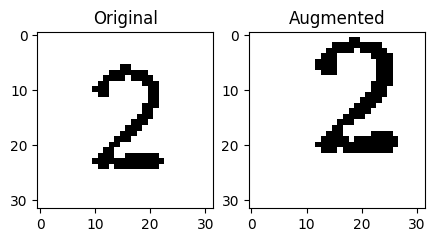

In [134]:
# An example of what augmentation does
fig, axes = plt.subplots(1, 2, figsize=(5, 2.5))
axes[0].imshow(digit_templates['2'], cmap='gray', vmax=255, vmin=0)
axes[0].set_title("Original")
axes[1].imshow(augment_image(digit_templates['2']), cmap='gray', vmax=255, vmin=0)
axes[1].set_title("Augmented")
plt.show()

In [10]:
# Create dataset
dataset_dir = r'/content/sample_data/digit_dataset'
os.mkdir(dataset_dir)

for label, img in digit_templates.items():
  os.mkdir(os.path.join(dataset_dir, label))

  for i in range(0,100):
    img_aug = augment_image(img)
    cv.imwrite(os.path.join(dataset_dir, label, f"{label}_{i}.png"), img_aug) # Save the image

In [11]:
# Zip and download dataset
# zip_name = "digit_dataset.zip"
# shutil.make_archive(zip_name.replace(".zip", ""), 'zip', dataset_dir)
# files.download(zip_name)

## Train a Model

The following cells train various classifiers. The first two classifiers use Scikit-learn models, followed by a CNN model trained with TensorFlow.

### Training Scikit-Learn Models

Below two models are trained. First, the dataset is processed to be compatible with Scikit-learn models and split into training and testing sets. Then, an SVM and an SGD model are trained. GridSearchCV is used to find the optimal hyperparameters for each model.


#### Data Preparation

In [14]:
# Prepare data for the scikit-learn models

dataset_dir = "/content/sample_data/digit_dataset"

# Prepare data storage
X = []  # Features (flattened images)
y = []  # Labels (digits 0-9)

# Load images from folders
for label in range(10):  # Loop through digit folders (0-9)
    folder_path = os.path.join(dataset_dir, str(label))  # e.g., "digit_dataset/0/"

    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)  # Load as grayscale

        if img is None:
            continue  # Skip invalid images

        img = scikit_image_preprocessing(img) # make data
        X.append(img)
        y.append(label)  # The folder name is the digit label

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y, dtype=np.uint8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 20% of data used for testing

#### SVM

In [15]:
# Train an SVM classifier

# params for tuning
hyper_param_grid = {
    'C': [0.1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf'],  # Kernel type
    'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1],  # Kernel coefficient for 'rbf', 'poly'
    'degree': [3, 4, 5],  # Degree of the polynomial kernel ('poly')
}

svm_model = svm.SVC()
grid_search = GridSearchCV(estimator=svm_model, param_grid=hyper_param_grid, refit = True, verbose = 1)
grid_search.fit(X_train, y_train)

# summarize the results of the grid search
print(f"The Model with params {grid_search.best_estimator_} got the best score of {grid_search.best_score_}.")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
The Model with params SVC(C=10) got the best score of 0.73625.


In [138]:
# set modelto the best model
svm_model = grid_search.best_estimator_

# Predict on test set
y_pred = svm_model.predict(X_test)

# # Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {accuracy:.2f}")

SVM Accuracy: 0.72


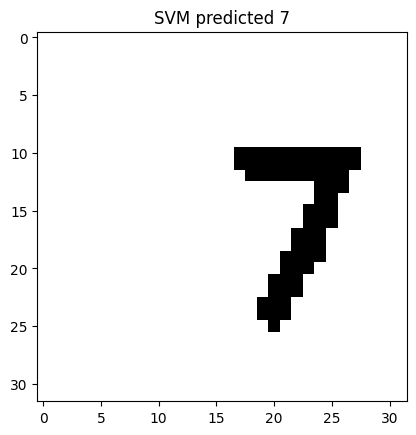

In [144]:
# Test model on single image
test_img_path = r'/content/sample_data/digit_dataset/7/7_5.png'
test_img = cv.imread(test_img_path, cv.IMREAD_GRAYSCALE)  # Load as grayscale
test_img_flat = scikit_image_preprocessing(test_img)
test_prediction = svm_model.predict([test_img_flat])
plt.imshow(test_img, cmap='gray', vmin=0, vmax=255)
plt.title(f"SVM predicted {test_prediction[0]}")
plt.show()

#### SGD

In [161]:
hyper_param_grid = {
    'loss': ['log_loss'], # Loss functions
    'penalty': ['l2', 'l1'],  # Regularization types
    'alpha': [0.01],  # Regularization strength
    'learning_rate': ['adaptive'], # Learning rate schedules
    'eta0': [1, 0.1],  # Initial learning rate
    'max_iter': [1000],  # Maximum number of iterations
}

sgd_model = SGDClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=sgd_model,
    param_grid=hyper_param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(f"The Model with params {grid_search.best_estimator_} got the best score of {grid_search.best_score_}.")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
The Model with params SGDClassifier(alpha=0.01, eta0=0.1, learning_rate='adaptive', loss='log_loss',
              random_state=42) got the best score of 0.49375.


In [162]:
# set model to best
sgd_model = grid_search.best_estimator_

# Predict on test set
y_pred = sgd_model.predict(X_test)

# # Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"SGD Accuracy: {accuracy:.2f}")

SGD Accuracy: 0.48


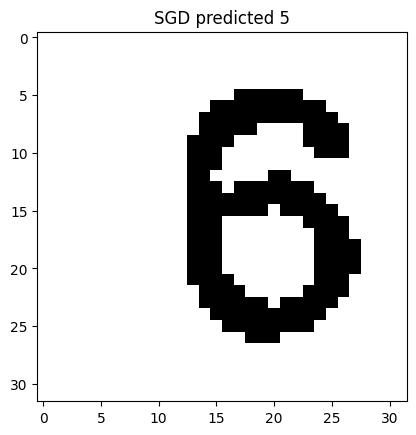

In [166]:
# Test model on single image
test_img_path = r'/content/sample_data/digit_dataset/6/6_5.png'
test_img = cv.imread(test_img_path, cv.IMREAD_GRAYSCALE)  # Load as grayscale
test_img_flat = scikit_image_preprocessing(test_img)
test_prediction = sgd_model.predict([test_img_flat])
plt.imshow(test_img, cmap='gray', vmin=0, vmax=255)
plt.title(f"SGD predicted {test_prediction[0]}")
plt.show()

### Train a Neural Network with TensorFlow

A CNN model is trained using TensorFlow. Among the trained classifiers, the CNN proves to be the most accurate. Therefore, it is the preferred solution for digit detection in the Sudoku solver program.


In [167]:
# Basic Variables
img_height = 32
img_width = 32
batch_size = 16

# Define model architecture
nn_model = Sequential([
    Input((img_height,img_width, 1)),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, 3, padding='same', activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax'),
])

# Load model and skip to example test
# nn_model = load_model("/content/sample_data/SNET.keras")

In [168]:
# setup dataset

ds_train = keras.preprocessing.image_dataset_from_directory(
    '/content/sample_data/digit_dataset',
    labels='inferred',
    label_mode='int',
    class_names=[str(i) for i in range(0,10)],
    color_mode='grayscale',
    batch_size=batch_size,
    image_size =(img_height,img_width),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='training'
)

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = ds_train.map(tf_image_preprocessing, num_parallel_calls=AUTOTUNE)

ds_validation = keras.preprocessing.image_dataset_from_directory(
    '/content/sample_data/digit_dataset',
    labels='inferred',
    label_mode='int',
    class_names=[str(i) for i in range(0,10)],
    color_mode='grayscale',
    batch_size=batch_size,
    image_size =(img_height,img_width),
    shuffle=True,
    seed=123,
    validation_split=0.1,
    subset='validation'
)

AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_validation = ds_validation.map(tf_image_preprocessing, num_parallel_calls=AUTOTUNE)

Found 1000 files belonging to 10 classes.
Using 900 files for training.
Found 1000 files belonging to 10 classes.
Using 100 files for validation.


Some Training Samples


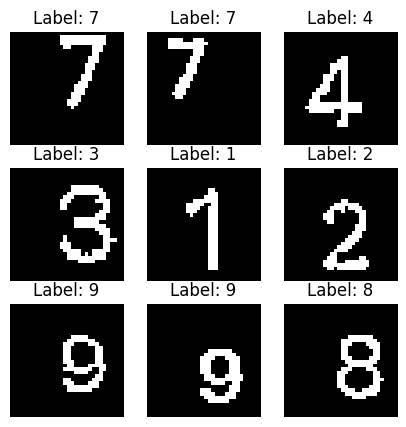

Batch Shapes:
Data:  (16, 32, 32, 1)
Labels:  (16,)


In [85]:
# view training data
print("Some Training Samples")
for images, labels in ds_train.take(1):
    # Determine the number of images to display (minimum of batch size or 9)
    num_images = min(images.shape[0], 9)
    # Create a figure to display the images
    plt.figure(figsize=(5, 5))
    for i in range(num_images):  # Display up to 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8").squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()

# View Batch Shapes
print("Batch Shapes:")
for image_batch, labels_batch in ds_train:
  print("Data: ", image_batch.shape)
  print("Labels: ", labels_batch.shape)
  break

In [ ]:
# Setup training procedure
nn_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=[
        keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    ],
    metrics=["accuracy"]
)

In [86]:
# Train and Test
print(f'\nTraining:')
nn_model.fit(ds_train, epochs=5, verbose=1)

test_loss, test_accuracy = nn_model.evaluate(ds_validation)
print(f'\nTesting:\nTest accuracy: {test_accuracy}, Test loss: {test_loss}')


Training:

Epoch 1/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.1955 - loss: 2.2025
Epoch 2/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.5352 - loss: 1.3237
Epoch 3/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.7356 - loss: 0.7105
Epoch 4/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.8935 - loss: 0.3190
Epoch 5/5
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9478 - loss: 0.1392
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9845 - loss: 0.0943

Testing:
Test accuracy: 0.9599999785423279, Test loss: 0.12866470217704773


Probs:
	0: 1.6679836678523685e-10
	1: 5.089407864034001e-07
	2: 4.904352863377426e-06
	3: 4.783801705343649e-05
	4: 2.814278786900104e-06
	5: 0.9986743927001953
	6: 0.00014646867930423468
	7: 3.7617606807316406e-08
	8: 0.0008881791727617383
	9: 0.00023500168754253536
Predicted digit: 5


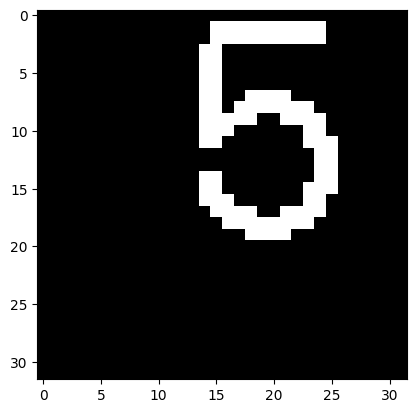

In [174]:
# Test model on single image
test_img_path = r'/content/sample_data/digit_dataset/5/5_87.png'
test_img = cv.imread(test_img_path, cv.IMREAD_GRAYSCALE)  # Load as grayscale
test_img = prep_model_input(test_img) # batch of images
test_prediction = nn_model.predict(test_img, verbose=0)[0]
print("Probs:")
for i, pred in enumerate(test_prediction):
    print(f"\t{i}: {pred}")
print(f"Predicted digit: {np.argmax(test_prediction)}")
plt.imshow(test_img[0], cmap='gray', vmin=0, vmax=1)
plt.show()

In [118]:
# Save model
nn_model.save("/content/sample_data/SNET.keras")

## Use Model to Generate Quize from Image

In [107]:
def load_quiz_cell_imagess():
    dir = r'/content/sample_data/quiz_cell_images'
    files = os.listdir(dir)
    cell_images = {}
    for file in files:
        img = cv.imread(os.path.join(dir,file), cv.IMREAD_GRAYSCALE)
        file_name = os.path.splitext(os.path.basename(file))[0]
        cell_images[file_name] = img
    return cell_images

cell_images = load_quiz_cell_imagess()

In [109]:
quiz_str_raw = ''

for i in range(1,82):
    cell_image = cell_images[str(i)]
    cell_image = prep_model_input(cell_image) # batch of images
    prediction = nn_model.predict(cell_image, verbose=0)[0]
    predicted_digit = np.argmax(prediction)
    quiz_str_raw += str(predicted_digit)

print("Raw quiz string: ", quiz_str_raw)

Raw quiz string:  400000960703400005020001004000830406096000010004106753072980500801007040500013327


In [110]:
def quiz_str_to_grid(quiz_str: str) -> np.array:
    """
    Converts a sudoku quiz in the string format of the dataset into a np.array
    """
    quiz_arr = np.array([np.uint8(c) for c in quiz_str])
    quiz_arr = quiz_arr.reshape(9, 9)
    return quiz_arr

def sudoku_grid_to_string(grid: np.array) -> str:
    """
    Creates a nice string representation of a sudoku grid.
    """
    formatted_rows = []
    for i, row in enumerate(grid):
        # Format the row with vertical separators for 3x3 blocks
        formatted_row = " | ".join(
            " ".join(str(cell) if cell != 0 else "." for cell in row[j:j+3])
            for j in range(0, 9, 3)
        )
        formatted_rows.append(formatted_row)

        # Add a horizontal separator every 3 rows
        if (i + 1) % 3 == 0 and i != 8:
            formatted_rows.append("-" * 21)  # Length matches the row format

    return "\n".join(formatted_rows)

In [111]:
quiz_grid = quiz_str_to_grid(quiz_str_raw)
quiz_str = sudoku_grid_to_string(quiz_grid)
print(quiz_str)

4 . . | . . . | 9 6 .
7 . 3 | 4 . . | . . 5
. 2 . | . . 1 | . . 4
---------------------
. . . | 8 3 . | 4 . 6
. 9 6 | . . . | . 1 .
. . 4 | 1 . 6 | 7 5 3
---------------------
. 7 2 | 9 8 . | 5 . .
8 . 1 | . . 7 | . 4 .
5 . . | . 1 3 | 3 2 7
